In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import scipy.stats as stats
#数据预处理：特征提取，归一化，划分数据集
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score      #交叉验证k-fold
from sklearn.ensemble import AdaBoostClassifier     #集成模型
from sklearn.model_selection import GridSearchCV     #超参数搜索
from sklearn.metrics import roc_curve,precision_recall_curve,auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix


In [2]:
data = pd.read_csv(r"C:\Users\11389\Desktop\第十一章数据集\教材数据集合\心脏衰竭预测数据\heart.csv")
data.columns = ['Age', 'Sex', '胸痛类型', '血压', '胆固醇', '血糖异常',
'心电图', '最大心率', '心绞痛', 'Oldpeak', 'ST_Slope',
'心脏病']
display(data.head())


,Age,Sex,胸痛类型,血压,胆固醇,血糖异常,心电图,最大心率,心绞痛,Oldpeak,ST_Slope,心脏病
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       918 non-null    int64  
 1   Sex       918 non-null    object 
 2   胸痛类型      918 non-null    object 
 3   血压        918 non-null    int64  
 4   胆固醇       918 non-null    int64  
 5   血糖异常      918 non-null    int64  
 6   心电图       918 non-null    object 
 7   最大心率      918 non-null    int64  
 8   心绞痛       918 non-null    object 
 9   Oldpeak   918 non-null    float64
 10  ST_Slope  918 non-null    object 
 11  心脏病       918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


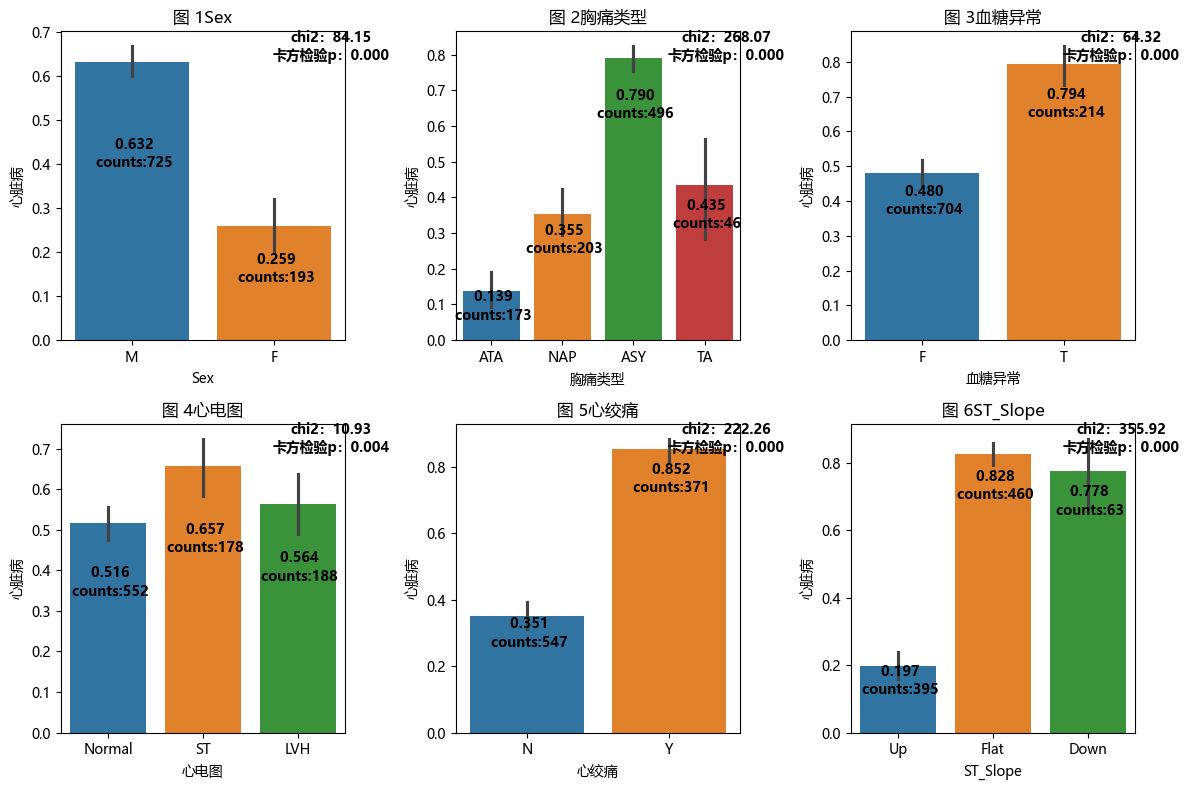

In [4]:
#1.41分类变量
#判断所有分类变量与y都有显著相关关系，所以全部采用热编码方法处理
#右边的序列为分类变量序列，最后一个为y
def trans01(x):
    if (x==1) :
        return 'T'
    else:
        return 'F'
data['血糖异常'] = data['血糖异常'].map(trans01)
temp = data.columns[[1,2,5,6,8,10,11]]
n = len(temp)
cols = int(np.ceil(np.sqrt(n-1)))
rows = int(np.ceil((n-1) / cols)) 
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 你可以选择其他中文字体，如 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()
# 绘制每个子图
for i in range(n-1):
    sns.barplot(x=temp[i], y=temp[-1], data=data,hue=temp[i], ax=axes[i])
    axes[i].set_title(f'图 {i + 1}{temp[i]}')  # 设置中文标题
    axes[i].set_xlabel(temp[i])        # 设置中文 x 轴标签
    axes[i].set_ylabel(temp[-1])  # 设置中文 y 轴标签
    contingency_table = pd.crosstab(data[temp[i]], data[temp[-1]])
    # 显示列联表
    #print(contingency_table)
    # 进行卡方检验(相关性)
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    #本身的峰度偏度
    #skew = stats.skew(data[temp[i]].value_counts())
    #kurtosis = stats.kurtosis(data[temp[i]].value_counts())
    #显示在右上角
    axes[i].text(0.95, 0.95, 'chi2：%.2f'%chi2+'\n卡方检验p：%.3f'%p_value, 
                 ha='center', va='center', 
                 transform=axes[i].transAxes, fontsize=10, color='black', weight='bold')

    for j in range(len(axes[i].patches)):  
        p = axes[i].patches[j]
        height = p.get_height()
        counts = data[temp[i]].value_counts()[axes[i].get_xticklabels()[j].get_text()]
        axes[i].text(1/(len(axes[i].patches))*(j+1/2), height, 
                     '\n %.3f' % height+'\n counts:%d' % counts,
                     ha='center', va='center',transform=axes[i].transAxes,
                     fontsize=10, color='black', weight='bold')
# 如果有多余的子图，隐藏它们
for i in range(n-1, len(axes)):
    axes[i].axis('off')
# 调整布局
plt.tight_layout()
plt.show()


In [5]:
x = data.drop(['心脏病'],axis=1)
y = data['心脏病']
x = pd.get_dummies(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=1)


In [6]:
clf0 = AdaBoostClassifier(random_state=66)
clf0.fit(x_train,y_train)
print('训练集score:%.7f' % clf0.score(x_train,y_train))
print('测试集score:%.7f' % clf0.score(x_test,y_test))


训练集score:0.8862928
测试集score:0.8586957


In [7]:
print('交叉验证score:%.7f' % np.mean(cross_val_score(clf0,x,y,cv=5)))

交叉验证score:0.8158708


In [8]:
clf1 = AdaBoostClassifier(n_estimators=100,learning_rate=0.1,random_state=66)
clf1.fit(x_train,y_train)
print('训练集score:%.7f' % clf1.score(x_train,y_train))
print('测试集score:%.7f' % clf1.score(x_test,y_test))
print('交叉验证score:%.7f' % np.mean(cross_val_score(clf1,x,y,cv=10)))


训练集score:0.8660436
测试集score:0.8659420
交叉验证score:0.8494744


In [9]:
param_full = {
    'estimator': [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),LinearSVC()], 
    'n_estimators': range(50, 300, 10),
    'learning_rate': np.arange(0, 1.1, 0.1),}
Gsearch = GridSearchCV(
    estimator= AdaBoostClassifier(),
    param_grid=param_full, scoring='accuracy',
    cv=5,n_jobs=-1)
Gsearch.fit(x_train, y_train)
print('最优组合:', Gsearch.best_params_)
print('test最佳得分：', Gsearch.best_score_)
_,learning_rate,n_estimators = list(Gsearch.best_params_.values())


最优组合: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.7000000000000001, 'n_estimators': 60}
test最佳得分： 0.8520106589147286


In [11]:
clf2=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),random_state=66,n_estimators=n_estimators,learning_rate=learning_rate)
clf2.fit(x_train,y_train)
y_pred_prob = clf2.predict_proba(x_test)[:, 1]
y_pred = clf2.predict(x_test) 
print('测试集score:%.7f' % clf2.score(x_train,y_train))
print('测试集score:%.7f' % clf2.score(x_test,y_test))
print('交叉验证score:%.7f' % np.mean(cross_val_score(clf2,x,y,cv=10)))
print('accuracy:%.7f' % accuracy_score(y_test, y_pred))
print('precision:%.7f' % precision_score(y_test, y_pred))
print('f1_score:%.7f' % f1_score(y_test, y_pred))
print('log_loss:%.7f' % log_loss(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('confusion_matrix:\n',cm)


测试集score:0.9906542
测试集score:0.8478261
交叉验证score:0.8397038
accuracy:0.8478261
precision:0.9139073
f1_score:0.8679245
log_loss:5.4849038
confusion_matrix:
 [[ 96  13]
 [ 29 138]]


confusion_matrix:
 [[ 96  13]
 [ 29 138]]


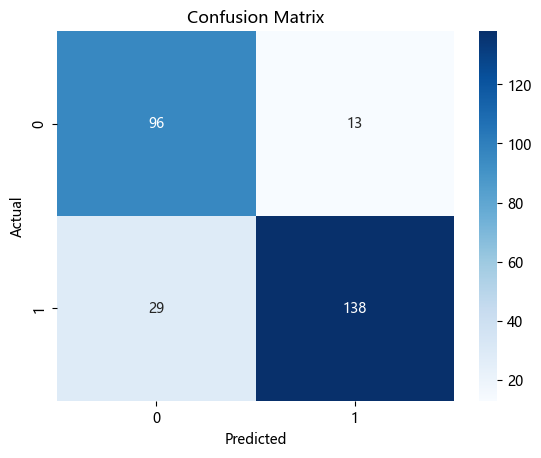

In [12]:
print('confusion_matrix:\n',cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


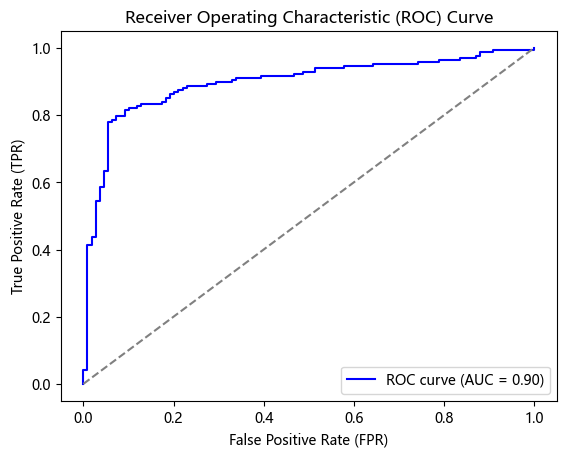

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()


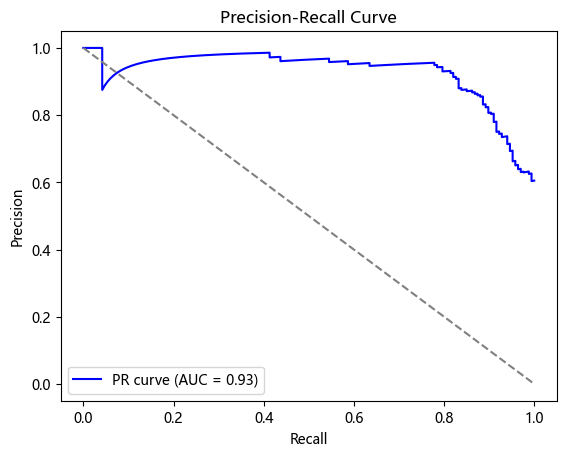

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.plot([0, 1], [1, 0], color='gray', linestyle='--')  # 随机分类器的基准线
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()
